# Assignment 5: Statistical Analysis (30 pt)

Use as many Python and markdown cells per question as you deem necessary. **DO NOT SUBMIT CODE THAT DOES NOT RUN.** You will lose points for code that throws errors. 

Questions 1 and 2 will use data describing various wetlands, intertidal zones, and ocean conditions in the United States from 1972-2015. This data has been adapted from [publicly available data from NASA](https://daac.ornl.gov/NACP/guides/Tidal_Wetland_Estuaries_Data.html). Note that this file uses the value `-9999` to denote missing data. This file's path is `data/tidal_wetland_estuaries.csv`.

Question 3 will be using time series data describing the proportion of electricity produced by coal in high income countries from [the World Bank](https://data.worldbank.org/indicator/EG.ELC.COAL.ZS). The path to the file is `data/coal-production.csv`.


## Question 1: t-tests (10 pt)

Using the data from `tidal_wetland_estuaries.csv`, test the hypothesis that soil organic carbon density (column name: `soc_density`) is **larger** in the East coast than the West coast with a t-test. Interpret the t-test. (5 pt)

Defend your choice of which type of t-test you used (3 pt).

Do the data meet the requirement for normal data? Why or why not? (2 pt) 

East Coast SOC Density:


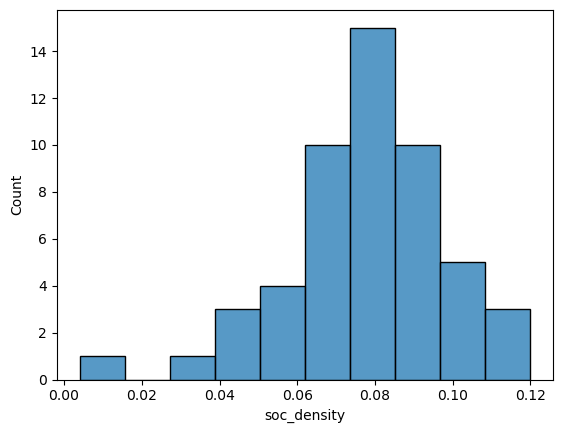

In [1]:
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

estuaries = pd.read_csv('data/tidal_wetland_estuaries.csv')

east = estuaries[estuaries['coast']=='EAST']['soc_density']
west = estuaries[estuaries['coast']=='WEST']['soc_density']

print('East Coast SOC Density:')
sns.histplot(east);

West Coast SOC Density:


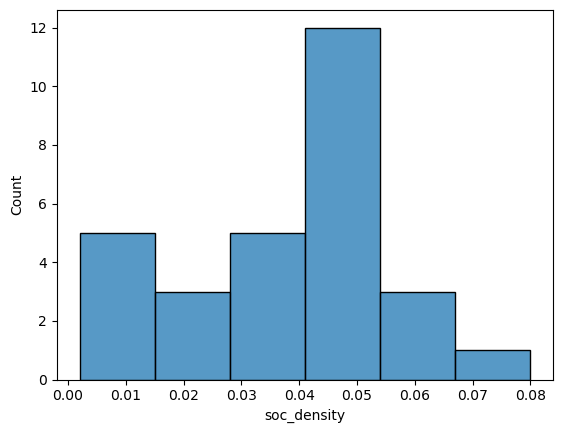

In [2]:
print('West Coast SOC Density:')
sns.histplot(west);

In [3]:
stats.ttest_ind(east, west, alternative='two-sided', nan_policy='omit')

Ttest_indResult(statistic=8.45031778669312, pvalue=1.1530568956025485e-12)

Since the p-value derived from the t-test is ~1.15e-12, we can say that the means of the two SOCs are significantly different at a 0.01 significance level.

In [4]:
print(f"""The Shapiro-Wilk p-value the for east coast is {stats.shapiro(east)[1]}, and the west coast is {stats.shapiro(west)[1]}. 
Since these values are > 0.5, they are assumed to be normally distributed.""")

The Shapiro-Wilk p-value the for east coast is 0.09766162186861038, and the west coast is 0.0792006105184555. 
Since these values are > 0.5, they are assumed to be normally distributed.


## Question 2

Using the data from `tidal_wetland_estuaries.csv`, create a linear model to predict mean ocean salinity (column name: `ocean_salinity_mean`) from other environmental factors. (2 pt)

Create a model with a high R-squared value (> 0.80). All coefficients should be significant, and none should have VIF values above 5.0. (4 pt)

Interpret the summary of the model, focusing on the R-squared value and the regression coefficients. (3 pt)

Make diagnostic plots to ensure your data meets the assumptions of linear regression. The necessary functions have been imported for you. (1 pt).

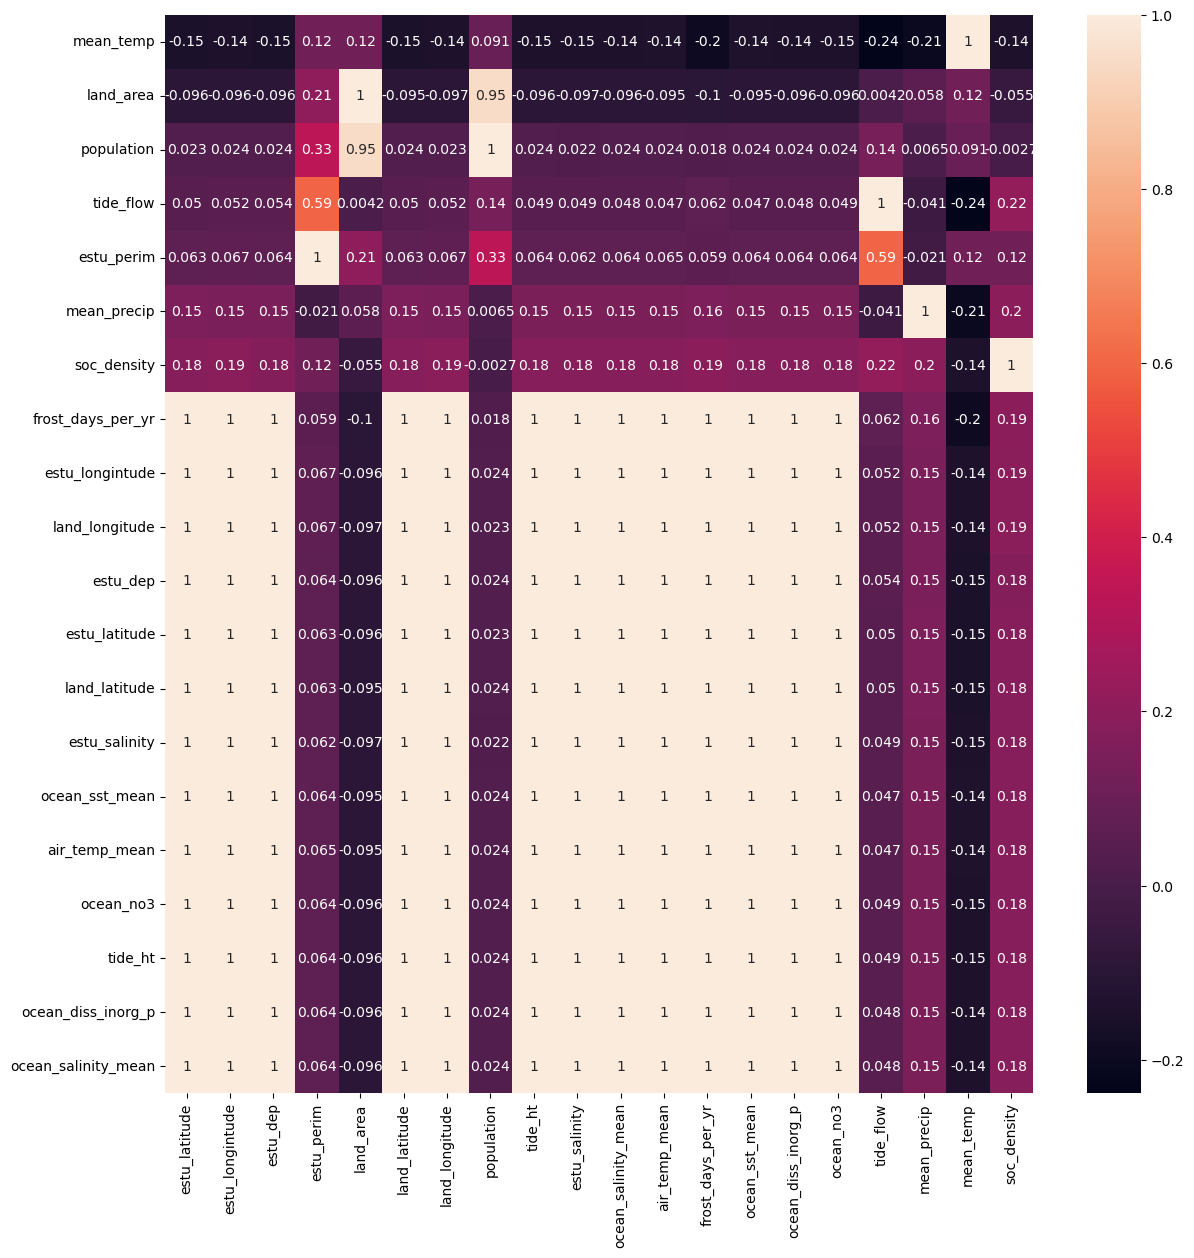

In [5]:
from utils import Linear_Reg_Diagnostic # do not change!

plt.rcParams["figure.figsize"] = [14, 14]
sns.heatmap(estuaries.corr().sort_values('ocean_salinity_mean'), annot=True);

In [6]:
filter = estuaries.corr().sort_values('ocean_salinity_mean', ascending=False)[['ocean_salinity_mean']]
correlation_cols = list(filter.index)
correlation_cols.remove('ocean_salinity_mean')
correlation_cols

['ocean_diss_inorg_p',
 'tide_ht',
 'ocean_no3',
 'air_temp_mean',
 'ocean_sst_mean',
 'estu_salinity',
 'land_latitude',
 'estu_latitude',
 'estu_dep',
 'land_longitude',
 'estu_longintude',
 'frost_days_per_yr',
 'soc_density',
 'mean_precip',
 'estu_perim',
 'tide_flow',
 'population',
 'land_area',
 'mean_temp']

In [7]:
for i in correlation_cols:
    print(i, end=" + ")

ocean_diss_inorg_p + tide_ht + ocean_no3 + air_temp_mean + ocean_sst_mean + estu_salinity + land_latitude + estu_latitude + estu_dep + land_longitude + estu_longintude + frost_days_per_yr + soc_density + mean_precip + estu_perim + tide_flow + population + land_area + mean_temp + 

In [8]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf


model1 = smf.ols(formula = "ocean_salinity_mean ~ ocean_diss_inorg_p + tide_ht + ocean_no3 + air_temp_mean + ocean_sst_mean + estu_salinity + land_latitude + estu_latitude + estu_dep + land_longitude + estu_longintude + frost_days_per_yr + soc_density + mean_precip + estu_perim + tide_flow + population + land_area + mean_temp", data=estuaries).fit()

In [9]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ocean_salinity_mean   R-squared:                       1.000
Model:                             OLS   Adj. R-squared:                  1.000
Method:                  Least Squares   F-statistic:                 1.482e+07
Date:                 Wed, 10 May 2023   Prob (F-statistic):          1.28e-298
Time:                         22:52:42   Log-Likelihood:                -92.534
No. Observations:                  115   AIC:                             225.1
Df Residuals:                       95   BIC:                             280.0
Df Model:                           19                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             31.6644      4.441      7.130      0.000      22.847      40.481
ocean_diss_inorg_p     1.0466      0.225      4.643      0.000       0.599       1.494
tide_ht                0.1190      0.104      1.145      0.255      -0.087       0.325
ocean_no3             -0.3731      0.126     -2.952      0.004      -0.624      -0.122
air_temp_mean         -0.1043      0.120     -0.867      0.388      -0.343       0.135
ocean_sst_mean         0.3075      0.068      4.510      0.000       0.172       0.443
estu_salinity          0.0187      0.010      1.829      0.071      -0.002       0.039
land_latitude         -0.1295      0.128     -1.012      0.314      -0.383       0.125
estu_latitude          0.0975      0.132      0.737      0.463      -0.165       0.360
estu_dep              -0.0022      0.005     -0.440      0.661      -0.012       0.008
land_longitude         0.1554      0.075      2.066      0.042       0.006       0.305
estu_longintude       -0.1413      0.075     -1.881      0.063      -0.290       0.008
frost_days_per_yr      0.0087      0.009      1.029      0.306      -0.008       0.026
soc_density            1.9920      2.934      0.679      0.499      -3.833       7.817
mean_precip           -0.0007      0.000     -2.942      0.004      -0.001      -0.000
estu_perim         -1.722e-07   1.01e-07     -1.698      0.093   -3.73e-07    2.91e-08
tide_flow           -2.22e-11   4.94e-11     -0.450      0.654    -1.2e-10    7.58e-11
population          6.888e-08   3.52e-08      1.956      0.053   -1.05e-09    1.39e-07
land_area          -1.337e-12   8.75e-13     -1.527      0.130   -3.07e-12    4.01e-13
mean_temp              0.0335      0.110      0.306      0.761      -0.184       0.251
==============================================================================
Omnibus:                        0.001   Durbin-Watson:                   0.621
Prob(Omnibus):                  0.999   Jarque-Bera (JB):                0.066
Skew:                          -0.007   Prob(JB):                        0.968
Kurtosis:                       2.884   Cond. No.                     2.28e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.28e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
diag1 = Linear_Reg_Diagnostic(model1)
diag1.vif_table()

              Features   VIF Factor
13         soc_density         2.24
15          estu_perim         2.47
16           tide_flow         3.08
14         mean_precip         4.19
18           land_area        19.36
17          population        20.12
19           mean_temp       111.74
0            Intercept      6401.97
9             estu_dep      7015.48
12   frost_days_per_yr     20564.14
6        estu_salinity     29369.84
5       ocean_sst_mean   1304998.03
11     estu_longintude   1550443.57
10      land_longitude   1554188.19
2              tide_ht   3022385.31
4        air_temp_mean   4065538.35
3            ocean_no3   4468281.50
7        land_latitude   4613046.79
8        estu_latitude   4937014.55
1   ocean_diss_inorg_p  14215910.38


c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\stats\outliers_influence.py:696: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


In [11]:
model2 = smf.ols(formula = "ocean_salinity_mean ~ ocean_diss_inorg_p + soc_density + mean_precip + estu_perim + tide_flow + mean_temp", data=estuaries).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ocean_salinity_mean   R-squared:                       1.000
Model:                             OLS   Adj. R-squared:                  1.000
Method:                  Least Squares   F-statistic:                 2.321e+07
Date:                 Wed, 10 May 2023   Prob (F-statistic):               0.00
Time:                         22:53:12   Log-Likelihood:                -140.40
No. Observations:                  115   AIC:                             294.8
Df Residuals:                      108   BIC:                             314.0
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             29.3900      0.418     70.349      0.000      28.562      30.218
ocean_diss_inorg_p     1.0035   8.78e-05   1.14e+04      0.000       1.003       1.004
soc_density           14.9131      2.957      5.043      0.000       9.052      20.774
mean_precip           -0.0010      0.000     -5.399      0.000      -0.001      -0.001
estu_perim         -2.193e-07   1.22e-07     -1.797      0.075   -4.61e-07    2.25e-08
tide_flow          -2.186e-11   5.53e-11     -0.395      0.693   -1.31e-10    8.78e-11
mean_temp              0.2754      0.017     16.459      0.000       0.242       0.309
==============================================================================
Omnibus:                        0.615   Durbin-Watson:                   0.440
Prob(Omnibus):                  0.735   Jarque-Bera (JB):                0.709
Skew:                           0.164   Prob(JB):                        0.701
Kurtosis:                       2.798   Cond. No.                     8.33e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.33e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
diag2 = Linear_Reg_Diagnostic(model2)
diag2.vif_table()

             Features  VIF Factor
1  ocean_diss_inorg_p        1.07
3         mean_precip        1.11
2         soc_density        1.13
6           mean_temp        1.29
4          estu_perim        1.77
5           tide_flow        1.91
0           Intercept       28.01


## Question 3 

Using the `coal-production.csv` data, model the proportion of electricity produced with coal in high income countries over time with an ARIMA model. 

Process the data to be useable for time series analysis. (2 pt)

Display your data. Does it appear to have a trend? If so, describe the trend. (1 pt)

Test for stationarity. (1 pt)

Make an ARIMA model of the time series, either by manually testing different types, or with an auto-ARIMA. What type of ARIMA model was found to be the best fit? (2 pt)

Visualize the fitted values of the ARIMA model, being sure to label each line. (2 pt)

Make a forecast for 25 years after the conclusion of the time series and visualize with observed and fitted values. (2 pt)

In [19]:
coal = pd.read_csv('data/coal-production.csv')
coal.head()

pd.to_datetime(coal['year'])
coal = coal.set_index('year').sort_index()
coal.head()

,electricity_prod
year,
1960,45.904345
1961,45.730794
1962,46.411172
1963,46.599523
1964,46.102588


Text(0, 0.5, 'Electricity')

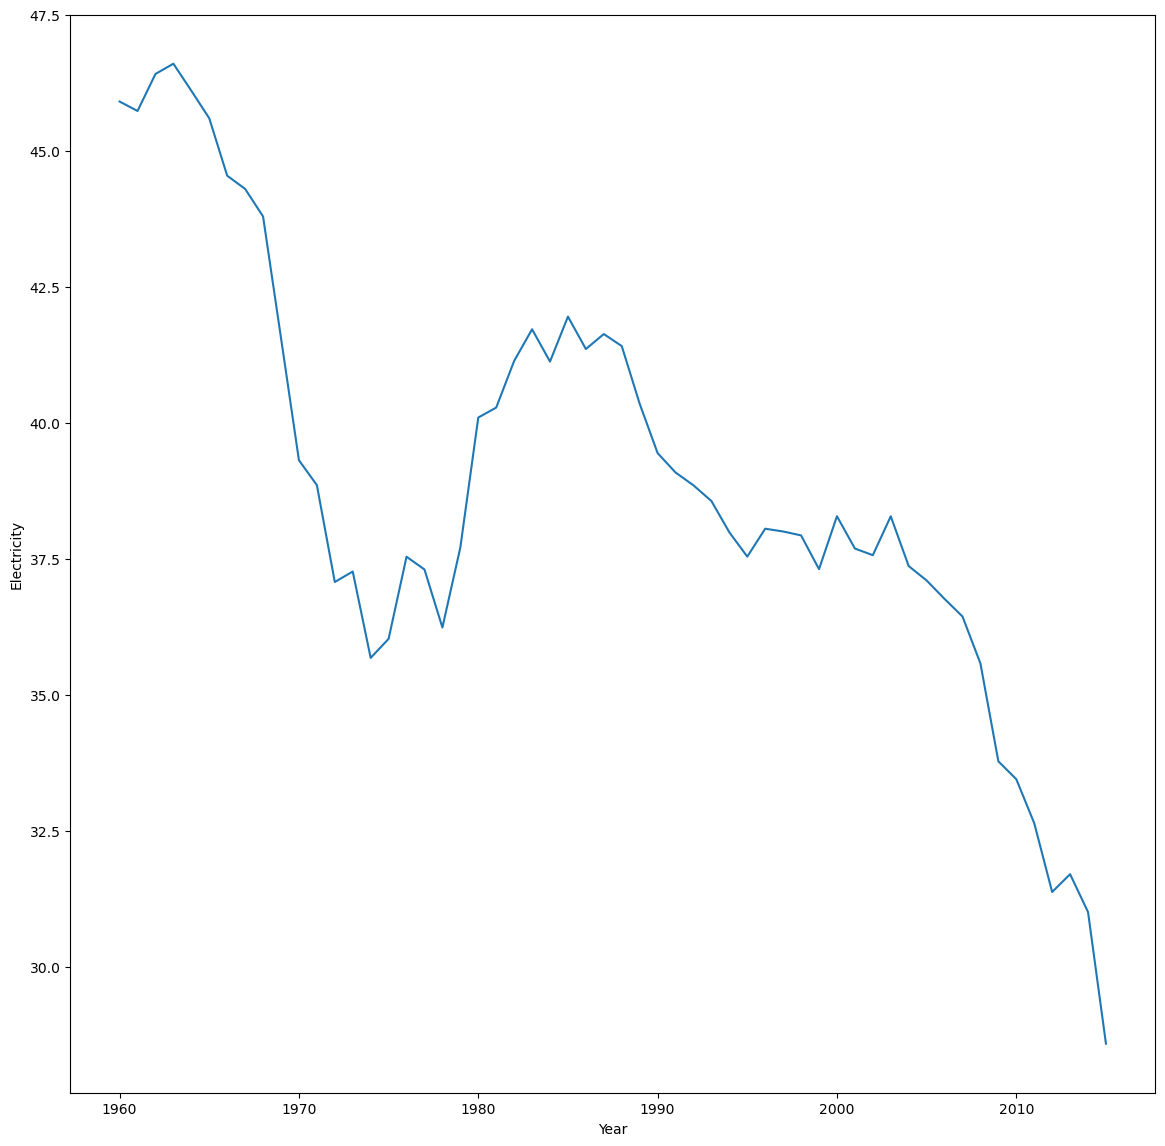

In [20]:
fig, ax = plt.subplots()
ax.plot(coal['electricity_prod']);
ax.set_xlabel('Year')
ax.set_ylabel('Electricity')

The data has a clear downward trend over time.

In [23]:
from statsmodels.tsa.stattools import adfuller

def adf_print(time_series):
    adf_output = adfuller(time_series)
    stat = adf_output[0]
    pval = adf_output[1]
    print('ADF Statistic:', stat)
    print('p-value:', pval)
    return None

adf_print(coal)

ADF Statistic: 1.8721544326758233
p-value: 0.9984818799941668


In [24]:
from statsmodels.tsa.arima.model import ARIMA


c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sari

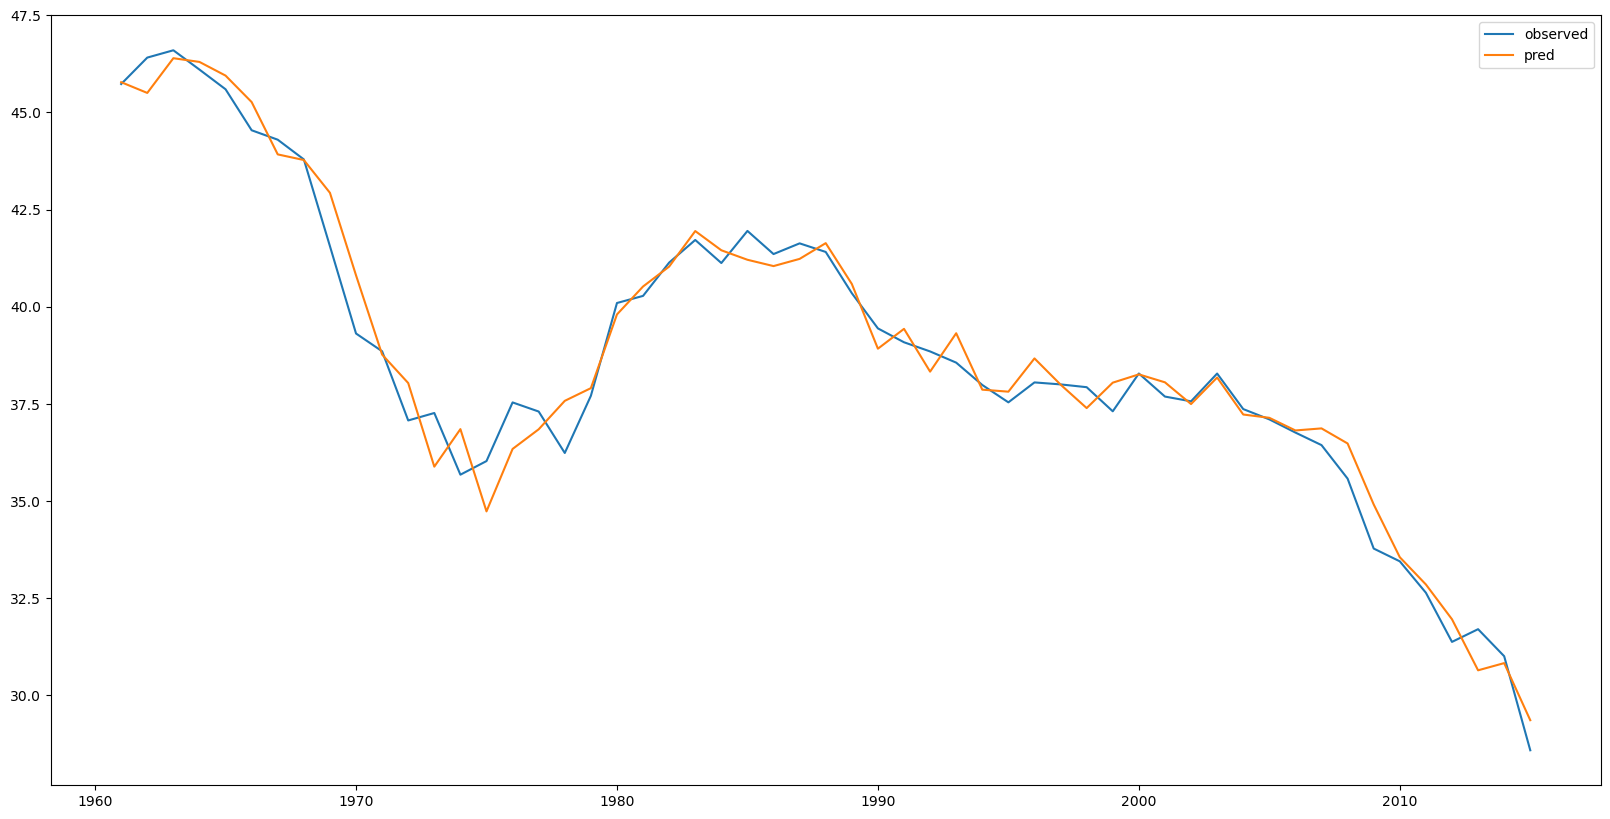

In [68]:
mod = ARIMA(coal['electricity_prod'], order=(20, 0, 10))
arima_model = mod.fit()

y_pred = arima_model.predict()

fig, ax = plt.subplots(figsize=(20,10)) 
ax.plot(coal['electricity_prod'][1:], label='observed')
ax.plot(y_pred[1:], label='pred')
ax.legend();

In [ ]:
arima_model.summary()

In [69]:
arima_model.mse

1.3232056009126947

By manual trial and error, 1.32 is the lowest mse I could find. This uses AR = 20, I = 0, MA = 10.

Now, using a for loop, I will check for ARIMA models that might have a lower mse.

In [71]:
ar = list(range(6))
i = list(range(6))
ma = list(range(6))

coal_prod = {
    'model':[],
    'aic':[]
}

for p in ar:
    for d in i:
        for q in ma:
            
            combo = str(p) + ','  + str(d) + ',' + str(q) 
            
            aic = ARIMA(coal, order = (p,d,q)).fit().aic
            
            coal['model'].append(combo)
            coal['aic'].append(aic)

coal_prod = pd.DataFrame(coal)

c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


KeyError: 'model'

In [75]:
model1 = ARIMA(coal, order=(19,0,8)).fit()
model2 = ARIMA(coal, order=(20,0,10)).fit()

c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarnin

In [76]:
print(model1.mse)
print(model2.mse)

1.3613536743269241
1.3232056009126947


In [77]:
print(model1.aic)
print(model2.aic)

169.8987741559639
174.14946902329658


In [78]:
coal_arima = ARIMA(coal['electricity_prod'], order=(20, 0, 10)).fit()
coal_arima.summary()

c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\perin\Applications\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sari

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       electricity_prod   No. Observations:                   56
Model:               ARIMA(20, 0, 10)   Log Likelihood                 -55.075
Date:                Wed, 10 May 2023   AIC                            174.149
Time:                        23:20:22   BIC                            238.961
Sample:                             0   HQIC                           199.277
                                 - 56                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.7972      5.226      7.424      0.000      28.554      49.040
ar.L1          0.0390      1.036      0.038      0.970      -1.992       2.070
ar.L2          0.0354      0.515      0.069      0.945      -0.975       1.045
ar.L3          0.5263      0.267      1.975      0.048       0.004       1.049
ar.L4          0.2826      0.785      0.360      0.719      -1.255       1.821
ar.L5          0.4851      0.706      0.687      0.492      -0.898       1.868
ar.L6          0.1526      0.640      0.238      0.812      -1.102       1.407
ar.L7          0.0313      0.373      0.084      0.933      -0.699       0.762
ar.L8         -0.4805      0.383     -1.254      0.210      -1.232       0.271
ar.L9         -0.4780      0.555     -0.861      0.389      -1.566       0.610
ar.L10        -0.4535      0.688     -0.659      0.510      -1.803       0.896
ar.L11         0.0163      0.757      0.022      0.983      -1.467       1.500
ar.L12         0.0788      0.550      0.143      0.886      -1.000       1.157
ar.L13         0.2858      0.371      0.770      0.441      -0.442       1.013
ar.L14         0.3568      0.475      0.751      0.453      -0.575       1.288
ar.L15         0.2134      0.747      0.286      0.775      -1.251       1.677
ar.L16         0.3162      0.551      0.574      0.566      -0.764       1.397
ar.L17        -0.0927      0.582     -0.159      0.874      -1.234       1.049
ar.L18        -0.1949      0.255     -0.764      0.445      -0.695       0.305
ar.L19        -0.5385      0.358     -1.505      0.132      -1.240       0.163
ar.L20         0.2887      0.716      0.403      0.687      -1.114       1.692
ma.L1          0.9457      2.098      0.451      0.652      -3.166       5.057
ma.L2          0.8500      2.057      0.413      0.680      -3.183       4.883
ma.L3          0.8246      2.869      0.287      0.774      -4.799       6.449
ma.L4          0.7882      2.620      0.301      0.764      -4.347       5.924
ma.L5          0.7897      1.514      0.522      0.602      -2.178       3.757
ma.L6          0.8480      2.586      0.328      0.743      -4.221       5.917
ma.L7          0.6719      3.105      0.216      0.829      -5.414       6.758
ma.L8          0.9543      3.740      0.255      0.799      -6.376       8.285
ma.L9          0.9113      3.841      0.237      0.812      -6.617       8.440
ma.L10         0.6600      1.989      0.332      0.740      -3.238       4.558
sigma2         0.2437      0.575      0.424      0.672      -0.883       1.371
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 0.54
Prob(Q):                              0.70   Prob(JB):                         0.76
Heteroskedasticity (H):               0.81   Skew:                             0.06
Prob(H) (two-sided):                  0.66   Kurtosis:                         2.54
========================================================

In [81]:
from pmdarima import auto_arima

auto_arima_model = auto_arima(coal['electricity_prod'])
auto_arima_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -71.684
Date:                Wed, 10 May 2023   AIC                            149.368
Time:                        23:22:16   BIC                            155.390
Sample:                             0   HQIC                           151.697
                                 - 56                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8478      0.140      6.074      0.000       0.574       1.121
ma.L1         -0.6020      0.230     -2.622      0.009      -1.052      -0.152
sigma2         0.7894      0.171      4.604      0.000       0.453       1.125
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.68   Prob(JB):                         0.51
Heteroskedasticity (H):               0.72   Skew:                             0.36
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

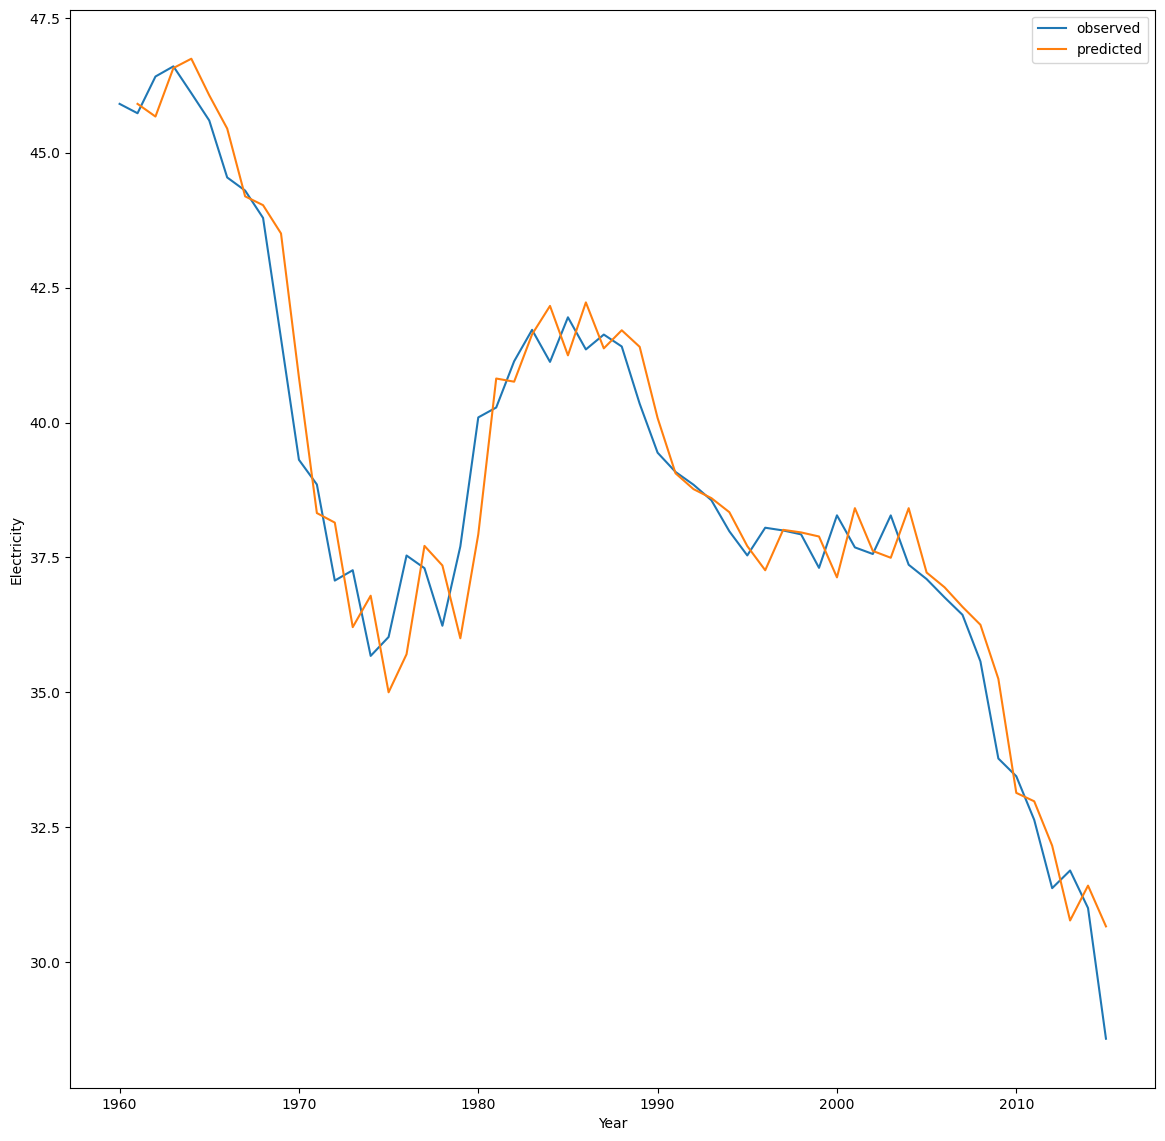

In [84]:
in_samp_pred = auto_arima_model.predict_in_sample()
in_samp_pred = pd.Series(in_samp_pred, index=coal.index)

fig, ax = plt.subplots()
ax.plot(coal, label='observed')
ax.plot(in_samp_pred[1:], label='predicted')
ax.set_xlabel('Year')
ax.set_ylabel('Electricity')
ax.legend();

In [ ]:
forecast, ci = auto_arima_model.predict(25, return_conf_int=True)
future_dates = pd.date_range(coal.index[-1], periods=26, freq='AS-JAN',inclusive='neither')

fig, ax = plt.subplots()
ax.plot(coal[1:], label='observed')
ax.plot(in_samp_pred[1:], label='predicted')
ax.plot(future_dates,forecast, label='forecast')
ax.fill_between(future_dates, ci[:,0], ci[:,1], color = 'gray', alpha=0.5) # our confidence intervals
ax.set_xlabel('Year')
ax.set_ylabel('Electricity')
ax.legend();